In [1]:
from sklearn import tree, metrics
import pandas as pd
from sklearn import model_selection
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

## Build a Decision Tree Classifier

The following method accepts a few model and hyper-parameter values and returns a decision tree.

In [50]:
def dt_train(X, y, **kwargs):
    max_depth = kwargs.get('max_depth', None)
    random_state = kwargs.get('random_state',7)
    criterion = kwargs.get('criterion', 'gini')
    min_impurity_split = kwargs.get('min_impurity_split', 0)
    ccp_alpha = kwargs.get('alpha', 0.0)
    balance = kwargs.get('balance')
    
    dt = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=random_state, criterion='entropy', 
                                     class_weight=balance, ccp_alpha=ccp_alpha, min_impurity_split=min_impurity_split)
    dt.fit(X, y)
    return dt

The following method accepts a decision tree classification model and perform post pruning

In [3]:
def prune(dt, X, y):
    path = dt.cost_complexity_pruning_path(X, y)
    return path

## Utilities for analysis

The following method builds a validation curve for a decision tree classification model based on a set of model and hyperparameter values. 

In [107]:
def plot_validation_curve(dt, X, y, param_name, param_range, cross_validation=5, fig_name="validation_curve.png",
                          xscale='linear'):
    tr_sc, tst_sc = model_selection.validation_curve(dt, X, y, param_name=param_name,
                                                            param_range=param_range, cv=cross_validation)
    plt.figure()
    plt.xticks(param_range)
    plt.xlabel(param_name)
    plt.xscale(xscale)
    plt.ylabel("Score")
    plt.plot(param_range, np.mean(tr_sc, axis=1), label='Training score')
    plt.plot(param_range, np.mean(tst_sc, axis=1), label='Cross-validation score')
    plt.legend(loc="best")
    plt.title('Decision Tree - Validation Curve')
    
    plt.savefig(fig_name)
    plt.show()


Get classification score

In [47]:
def get_classification_score(dt, X, y):
    return dt.score(X, y)

def get_f1_score(dt, X, y):
    yp = dt.predict(X)
    return metrics.f1_score(y, yp, average="weighted")

The following function provides a visual representation for the decision tree

In [6]:
def visualize_dt(dt, feature_names, target_names):
    exp_tree = tree.export_graphviz(dt, out_file=None, 
                      feature_names=feature_names,  
                      class_names=target_names,  
                      filled=True, rounded=True)
    return graphviz.Source(exp_tree)
    

## Census Data Analysis
Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

Prediction task is to determine whether a person makes over 50K a year.

In [7]:
data = pd.read_csv("adult.data", sep='\t', header=None, 
                   names=["age", "workclass", "fnlwgt", "education", 
                          "education-num", "marital-status", "occupation",
                          "relationship", "race", "sex", "capital-gain", 
                          "capital-loss", "hours-per-week", "native-country", 
                          "output"])
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,output
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


From the pearson correlation plot below, it can be inferred that there is not much correlation between the input columns and the output value.

Now, let us take a look at the number of samples for each of the discrete output values. 

<AxesSubplot:xlabel='output', ylabel='count'>

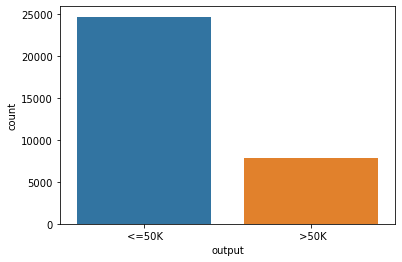

In [8]:
sns.countplot(x="output", data=data)

There is a gap between the number of persons who make >50k/year vs the number of persons who do not. 

In [9]:
categorical_vars =["workclass", "education", "marital-status", "occupation", "relationship", 
                   "race", "sex", "native-country"]
df = data.copy()
for var in categorical_vars:
    df[var] = pd.Categorical(df[var])
    df[var] = df[var].cat.codes

continuous_vars = ["fnlwgt", "capital-gain", "capital-loss"]
for var in continuous_vars:
    df[var] = (df[var]-df[var].mean())/df[var].std()

normalized_df=(df-df.mean())/df.std()
y = df.output.values
X = df.drop(['output'], axis=1)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,output
0,39,7,-1.063594,9,13,4,1,1,4,1,0.148451,-0.216656,40,39,<=50K
1,50,6,-1.008692,9,13,2,4,0,4,1,-0.145918,-0.216656,13,39,<=50K
2,38,4,0.245075,11,9,0,6,1,4,1,-0.145918,-0.216656,40,39,<=50K
3,53,4,0.425795,1,7,2,6,0,2,1,-0.145918,-0.216656,40,39,<=50K
4,28,4,1.408154,9,13,2,10,5,2,0,-0.145918,-0.216656,40,5,<=50K


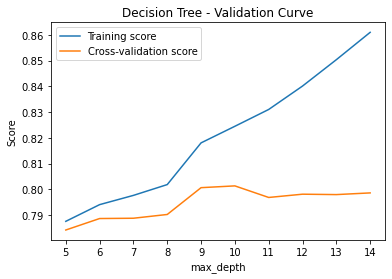

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
plot_validation_curve(tree.DecisionTreeClassifier(class_weight="balanced"), X_train, y_train, 'max_depth', range(5, 15), 
                      fig_name="max_depth_vc.png")

Now let us call the training function with max depth as 4 and take a look at the results. 

In [11]:
dt = dt_train(X_train, y_train, max_depth=10, balance="balanced")

Now let us measure the performance of the model on the test set:

In [48]:
print("Score:", get_classification_score(dt, X_test, y_test))
print("F1-Score (Weighted):",get_f1_score(dt, X_test, y_test))

Score: 0.811761093198219
F1-Score (Weighted): 0.8221669568637731


As there are too much of negative examples, it is important to see confusion matrix to measure the actual model performance. 

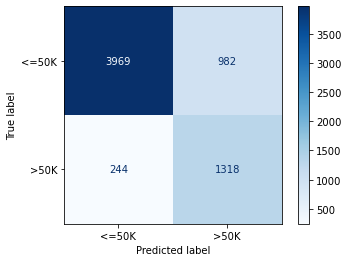

In [13]:
plot_confusion_matrix(dt, X_test, y_test,
                                 display_labels=['<=50K', '>50K'],
                                 cmap=plt.cm.Blues)
plt.show()

With the above model, it can be seen that the model does not fit well to positive examples. 

### Post Pruning
One way to deal with this is allow the model to overfit the data and perform post pruning.

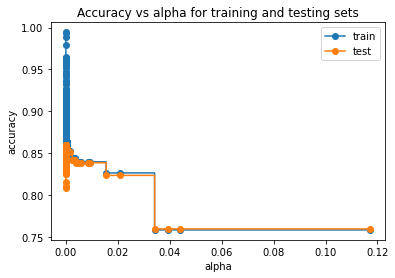

In [39]:
dt_final = dt_train(X_train, y_train, max_depth=30)
path = prune(dt_final, X_train, y_train)
ccp_alphas = path.ccp_alphas
clfs = []
for ccp_alpha in ccp_alphas:
    dt_f = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, max_depth=30)
    dt_f.fit(X_train, y_train)
    clfs.append(dt_f)
    
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [40]:
dt_f = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[np.argmax(test_scores)], max_depth=30)
dt_f.fit(X_train, y_train)
dt_f.score(X_test, y_test)

0.8595117457392907

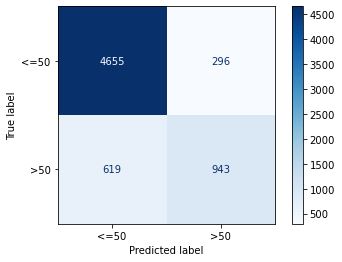

In [41]:
plot_confusion_matrix(dt_f, X_test, y_test,
                                 display_labels=['<=50', '>50'],
                                 cmap=plt.cm.Blues)
plt.show()

Although we allow the model to overfit and perform post pruning, the model does not perform well on positive examples. Let us take a look at the f1-score for the pruned trees and choose the model that balances both of these classes. 

In [42]:
f1_scores_pos = []
f1_scores_neg = []
for clf in clfs:
    y_actual = clf.predict(X_test)
    f1_scores_pos.append(metrics.f1_score(y_test, y_actual, pos_label=' >50K'))
    f1_scores_neg.append(metrics.f1_score(y_test, y_actual, pos_label=' <=50K'))

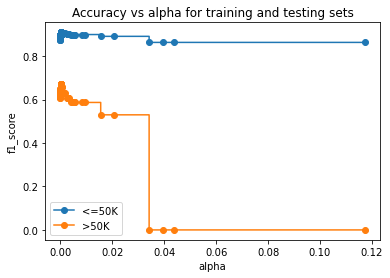

In [43]:
fig, ax = plt.subplots()
    
ax.set_xlabel("alpha")
ax.set_ylabel("f1_score")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, f1_scores_neg, marker='o', label="<=50K",
        drawstyle="steps-post")
ax.plot(ccp_alphas, f1_scores_pos, marker='o', label=">50K",
        drawstyle="steps-post")
ax.legend()

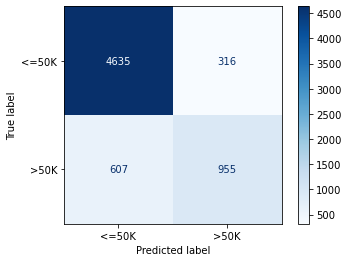

In [46]:
dt_f_pos = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[np.argmax(f1_scores_pos)], max_depth=30)
dt_f_pos.fit(X_train, y_train)
plot_confusion_matrix(dt_f_pos, X_test, y_test,
                                 display_labels=['<=50K', '>50K'],
                                 cmap=plt.cm.Blues)
plt.show()

In [49]:
print("Score: ", get_classification_score(dt_f_pos, X_test, y_test))
print("F1 Score: ", get_f1_score(dt_f_pos, X_test, y_test))

Score:  0.8582834331337326
F1 Score:  0.8530279477598063


### Pre-pruning
Another way to avoid large decision trees that overfit the data is to prevent the nodes from being created using certain criteria.

C:\Users\NS_PC\Anaconda3\envs\ml\lib\site-packages\sklearn\tree\_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
C:\Users\NS_PC\Anaconda3\envs\ml\lib\site-packages\sklearn\tree\_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
C:\Users\NS_PC\Anaconda3\envs\ml\lib\site-packages\sklearn\tree\_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
C:\Users\NS_PC\Anaconda3\envs\ml\lib\site-packages\sklearn\tree\_classes.py:310: FutureW

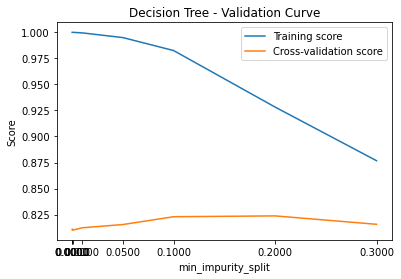

In [57]:
plot_validation_curve(tree.DecisionTreeClassifier(class_weight="balanced"),
                      X_train, y_train,
                      "min_impurity_split", [0.00001, 0.0001, 0.001,  0.01, 0.05, 0.1, 0.2, 0.3])

Let us select 0.05 as the min_impurity_split value as it performs decently in both training and validation set

In [63]:
dt_pre = dt_train(X_train, y_train, min_impurity_split=0.05)

print("Score: ", get_classification_score(dt_pre, X_test, y_test))
print("F1 Score: ", get_f1_score(dt_pre, X_test, y_test))

Score:  0.8245048364808844
F1 Score:  0.825386933968392


C:\Users\NS_PC\Anaconda3\envs\ml\lib\site-packages\sklearn\tree\_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


# Phishing Dataset Analysis

The dataset aims to identify phishing websites based on various attributes. 

In [77]:
from scipy.io.arff import loadarff 

raw_data = loadarff('Training Dataset.arff')
ph_data = pd.DataFrame(raw_data[0])
ph_data.head()

for var in ph_data.columns.values:
    ph_data[var] = pd.Categorical(ph_data[var])
    ph_data[var] = ph_data[var].cat.codes

<AxesSubplot:xlabel='Result', ylabel='count'>

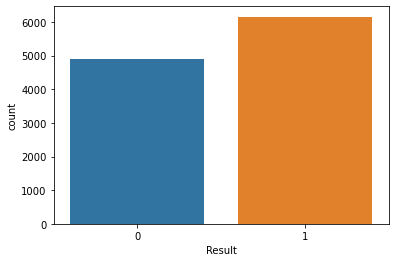

In [78]:
sns.countplot(x="Result", data=ph_data)

There is no class-imbalance like the previous dataset. 

In [79]:
y = ph_data.Result.values
X = ph_data.drop(['Result'], axis=1)

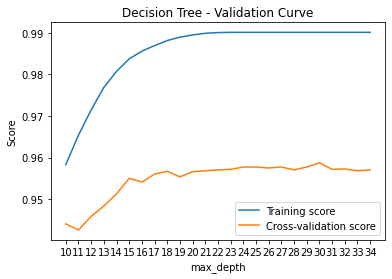

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
plot_validation_curve(tree.DecisionTreeClassifier(), X_train, y_train, 'max_depth', range(10, 35), 
                      fig_name="max_depth_vc.png")

Now, let us select max_depth=30 and measure the model performance. 

In [90]:
dt = dt_train(X_train, y_train, max_depth=30)

C:\Users\NS_PC\Anaconda3\envs\ml\lib\site-packages\sklearn\tree\_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


In [91]:
print("Score:", get_classification_score(dt, X_test, y_test))
print("F1-Score (Weighted):",get_f1_score(dt, X_test, y_test))

Score: 0.9710538218000905
F1-Score (Weighted): 0.9710569563750262


Time to look at the confusion matrix.

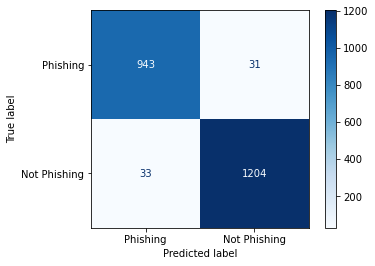

In [95]:
plot_confusion_matrix(dt, X_test, y_test,
                                 display_labels=['Phishing', 'Not Phishing'],
                                 cmap=plt.cm.Blues)
plt.show()

From the confusion matrix, we can infer that the decision tree model does justice to both the classes. 

As there isn't a noticeable class imbalance, f1 score analysis is not required. 


### Post-pruning
Now, let us take a look at the performance of DT with post-pruning on the phising websites dataset.

C:\Users\NS_PC\Anaconda3\envs\ml\lib\site-packages\sklearn\tree\_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


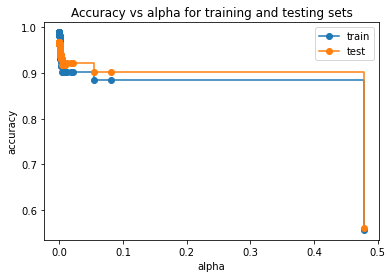

In [93]:
dt = dt_train(X_train, y_train, max_depth=100)
path = prune(dt_final, X_train, y_train)
ccp_alphas = path.ccp_alphas
clfs = []
for ccp_alpha in ccp_alphas:
    dt_f = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, max_depth=30)
    dt_f.fit(X_train, y_train)
    clfs.append(dt_f)
    
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [94]:
dt_f = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[np.argmax(test_scores)], max_depth=100)
dt_f.fit(X_train, y_train)
dt_f.score(X_test, y_test)

0.968340117593849

### Pre-pruning

C:\Users\NS_PC\Anaconda3\envs\ml\lib\site-packages\sklearn\tree\_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
C:\Users\NS_PC\Anaconda3\envs\ml\lib\site-packages\sklearn\tree\_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
C:\Users\NS_PC\Anaconda3\envs\ml\lib\site-packages\sklearn\tree\_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
C:\Users\NS_PC\Anaconda3\envs\ml\lib\site-packages\sklearn\tree\_classes.py:310: FutureW

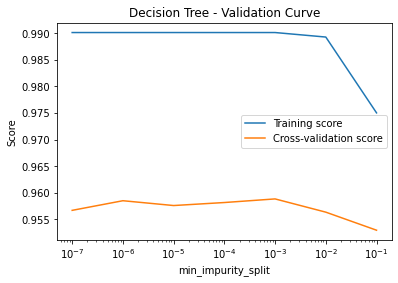

In [111]:
plot_validation_curve(tree.DecisionTreeClassifier(),
                      X_train, y_train,
                      "min_impurity_split", [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1], xscale='log')

10^-3 works the est for min_impurity_split. Let us measure the actual performance of pre-pruning. 

In [113]:
dt_pre = dt_train(X_train, y_train, min_impurity_split=0.001)

print("Score: ", get_classification_score(dt_pre, X_test, y_test))
print("F1 Score: ", get_f1_score(dt_pre, X_test, y_test))

Score:  0.9710538218000905
F1 Score:  0.9710569563750262


C:\Users\NS_PC\Anaconda3\envs\ml\lib\site-packages\sklearn\tree\_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
